In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import copy
import time
import pandas as pd

DEBUG = False

# Utility functions

In [2]:
def log(message):
    if(DEBUG):
        print(message)

# Game Engine
Basic 2048 game engine. Defines the game state, transition function, and evaluation function

In [3]:
class Game():
    def __init__(self):
        self.board = np.zeros([4, 4])
        self.last = None

    def new_piece(self):
        flattened_board = self.board.reshape(16)
        empty_spots = np.where(flattened_board == 0)[0]
        
        if len(empty_spots) == 0:
            return False
        else:
            new_spot = empty_spots[random.randint(0, len(empty_spots) - 1)]
            log(f"New cell created at {math.trunc(new_spot / 4)},{new_spot % 4}")
            flattened_board[new_spot] = 2 if random.randint(0, 10) else 4
            self.board = flattened_board.reshape(4, 4)

        return True


    def has_won(self):
        return np.any(self.board >= 2048) and not any(self.can_move(direction) for direction in ['L', 'R', 'U', 'D'])

    def has_lost(self):
        return not any(self.can_move(direction) for direction in ['L', 'R', 'U', 'D']) and not np.any(self.board >= 2048)

    def status(self):
        # Determine game status based on game conditions
        if any(self.can_move(direction) for direction in ['L', 'R', 'U', 'D']):
            return "Game Ongoing"
        elif self.has_won():
            return "Game Won"
        elif self.has_lost():
            return "Game Lost"
        else:
            return "Unknown State"
        
    def can_move(self, direction):
        if direction == 'L':  # Move left
            for row in self.board:
                for i in range(1, 4):
                    if row[i] != 0 and (row[i - 1] == 0 or row[i - 1] == row[i]):
                        return True
        elif direction == 'R':  # Move right
            for row in self.board:
                for i in range(2, -1, -1):
                    if row[i] != 0 and (row[i + 1] == 0 or row[i + 1] == row[i]):
                        return True
        elif direction == 'U':  # Move up
            for col in range(4):
                for row in range(1, 4):
                    if self.board[row][col] != 0 and (self.board[row - 1][col] == 0 or self.board[row - 1][col] == self.board[row][col]):
                        return True
        elif direction == 'D':  # Move down
            for col in range(4):
                for row in range(2, -1, -1):
                    if self.board[row][col] != 0 and (self.board[row + 1][col] == 0 or self.board[row + 1][col] == self.board[row][col]):
                        return True
        return False

    def transition_left(self):    
        for m in range(0, 4):
            merged = False # only allow one merge per row per turn, as per the rules
            
            for i in range(0, 4):
                for n in range(1, 4):
                    if not self.board[m][n] == 0 and not merged and self.board[m][n - 1] == self.board[m][n]:
                        log(f"Cells merged into {m},{n - 1}")
                        self.board[m][n - 1], self.board[m][n] = self.board[m][n - 1] * 2, 0
                        merged = True
                        
                    if self.board[m][n - 1] == 0 and self.board[m][n] != 0:
                        self.board[m][n - 1], self.board[m][n] = self.board[m][n], 0

    def transition_right(self):
        for m in range(0, 4):
            merged = False # only allow one merge per row per turn, as per the rules

            for i in range(0, 4):
                for n in range(2, -1, -1):
                    if not self.board[m][n] == 0 and not merged and self.board[m][n] == self.board[m][n + 1]:
                        log(f"Cells merged into {m},{n + 1}")
                        self.board[m][n], self.board[m][n + 1] = 0, self.board[m][n] * 2
                        merged = True
                    
                    if self.board[m][n] != 0 and self.board[m][n + 1] == 0:
                        self.board[m][n], self.board[m][n + 1] = 0, self.board[m][n]
            
    def transition_up(self):
        for n in range(0, 4):
            merged = False # only allow one merge per column per turn, as per the rules
            
            for i in range(0, 4):
                for m in range(1, 4):
                    if not self.board[m][n] == 0 and not merged and self.board[m - 1][n] == self.board[m][n]:
                        log(f"Cells merged into {m - 1},{n}")
                        self.board[m - 1][n], self.board[m][n] = self.board[m - 1][n] * 2, 0
                        merged = True
                        
                    if self.board[m - 1][n] == 0 and self.board[m][n] != 0:
                        self.board[m - 1][n], self.board[m][n] = self.board[m][n], 0

    def transition_down(self):
        for n in range(0, 4):
            merged = False # only allow one merge per column per turn, as per the rules

            for i in range(0, 4):
                for m in range(2, -1, -1):
                    if not self.board[m][n] == 0 and not merged and self.board[m][n] == self.board[m + 1][n]:
                        log(f"Cells merged into {m + 1},{n}")
                        self.board[m][n], self.board[m + 1][n] = 0, self.board[m][n] * 2
                        merged = True
                    
                    if self.board[m][n] != 0 and self.board[m + 1][n] == 0:
                        self.board[m][n], self.board[m + 1][n] = 0, self.board[m][n]
    
    def transition(self, direction):
        if self.can_move(direction):
            match direction:
                case 'L':
                    self.transition_left()
                case 'R':
                    self.transition_right()
                case 'U':
                    self.transition_up()
                case 'D':
                    self.transition_down()
            
            self.last = direction
            self.new_piece()
    
    def set_board(self, _board):
        if not isinstance(_board, np.ndarray):
            _board = np.array(_board)
            
        self.board = _board 


# Simple evaluation function

In [4]:
def simple_evaluation_function(board):
    # Simple evaluation function based on the number of empty cells and the sum of tile values
    empty_cells = np.sum(board == 0)
    score = np.sum(board)  # sum of all tiles
    return score + empty_cells * 100  # weighted sum and empty cells count for flexibility

# Highest corner evaluation function

In [5]:


def cornered_evaluation_function(board):
    max_val = np.max(board)
    empty_cells = np.sum(board == 0)
    highest_corners = 0

    if board[0, 0] == max_val:
        highest_corners += 1
    if board[board.shape[0] - 1, 0] == max_val:
        highest_corners += 1
    if board[0, board.shape[1] - 1] == max_val:
        highest_corners += 1
    if board[board.shape[0] - 1, board.shape[1] - 1] == max_val:
        highest_corners += 1
    
    score = np.sum(board) 
    return score + empty_cells * 100 + highest_corners * max_val 

# Linear Paramaterizable evaluation function (and utilities)

In [6]:
def count_horiz_seqs(x):
    ct = 0
    
    for i in range(0, x.shape[0]):
        for j in range(0, x.shape[1] - 1):
            if x[i, j] > 0 and x[i, j] == x[i, j + 1]:
                ct += 1
                
    return ct

def count_seqs(x):
    return count_horiz_seqs(x) + count_horiz_seqs(x.transpose())

def term(x, prio):
    return x * 2 ** prio

def linear_evaluation_function_curry(args):
    [prio_empty_cells, prio_count_seqs, prio_max_value, prio_avg] = args
    
    def linear_evaluation_function(board):
        empty_cells = np.sum(board == 0)
        max_value = np.max(board)
        avg_value = np.sum(board) // 16
        
        return term(empty_cells, prio_empty_cells) + term(count_seqs(board), prio_count_seqs) + term(max_value, prio_max_value) + term(avg_value, prio_avg)
    return linear_evaluation_function 

# SearchAlgorithm
Abstract class the defines the basic interface for all search algorithms

In [7]:
class SearchAlgorithm:
    def __init__(self, game, evaluation_function = simple_evaluation_function):
        self.game = game
        self.evaluation_function = evaluation_function

    def best_move(self, *args):
        raise NotImplementedError

# Expectimax
Implementation of Expectimax

In [8]:
class Expectimax(SearchAlgorithm):
    def __init__(self, game, evaluation_function = simple_evaluation_function):
        super().__init__(game, evaluation_function)
        
    def expectimax(self, depth, is_max_node=True):
        # Termination conditions
        if depth == 0 or self.game.has_won() or self.game.has_lost():
            return self.evaluation_function(self.game.board)
        
        if is_max_node:  # Max node (player's turn)
            max_score = float('-inf')
            for direction in ['L', 'R', 'U', 'D']:
                if self.game.can_move(direction):
                    # Simulate the move
                    new_game = Game()
                    new_game.board = np.copy(self.game.board)
                    new_game.transition(direction)
                    
                    # Recurse to find the expectimax score
                    score = Expectimax(new_game, self.evaluation_function).expectimax(depth - 1, is_max_node=False)
                    max_score = max(max_score, score)
                    
            return max_score

        else:  # Chance node (random tile placement)
            expected_score = 0
            empty_positions = list(zip(*np.where(self.game.board == 0)))
            
            # Chance of placing 2 or 4
            for position in empty_positions:
                # Try placing a '2' with probability 0.9
                new_game_2 = Game()
                new_game_2.board = np.copy(self.game.board)
                new_game_2.board[position] = 2
                expected_score += 0.9 * Expectimax(new_game_2, self.evaluation_function).expectimax(depth - 1, is_max_node=True)
                
                # Try placing a '4' with probability 0.1
                new_game_4 = Game()
                new_game_4.board = np.copy(self.game.board)
                new_game_4.board[position] = 4
                expected_score += 0.1 * Expectimax(new_game_4, self.evaluation_function).expectimax(depth - 1, is_max_node=True)
                
            # Average score for chance node
            return expected_score / len(empty_positions) if empty_positions else 0

    def best_move(self, depth=3):
        # Find the best move using expectimax
        best_score = float('-inf')
        best_direction = None

        for direction in ['L', 'R', 'U', 'D']:
            if self.game.can_move(direction):
                # Create a copy of the game and apply the move
                new_game = Game()
                new_game.board = np.copy(self.game.board)
                new_game.transition(direction)
                
                # Use expectimax to evaluate this move
                score = Expectimax(new_game, self.evaluation_function).expectimax(depth - 1, is_max_node=False)
                if score > best_score:
                    best_score = score
                    best_direction = direction

        return best_direction            

# MCTS
Implementation of the Monte Carlo Tree Search

In [9]:
class Node:
    def __init__(self, game, parent=None):        
        self.game = copy.deepcopy(game)      # Store a copy of the game state
        self.parent = parent                 # Parent node
        self.children = []                   # List of child nodes
        self.visits = 0                      # Number of times this node was visited
        self.score = 0                       # Total score of simulations from this node
    
    def is_fully_expanded(self):
        return len(self.children) == len(self.get_legal_moves())
    
    def get_legal_moves(self):
        # Return available moves (['L', 'R', 'U', 'D'] if possible)
        return [move for move in ['L', 'R', 'U', 'D'] if self.game.can_move(move)]
    
    def uct_score(self, exploration_param=1.41):
        if self.visits == 0:
            return float('inf')  # If unvisited, prioritize visiting
        return self.score / self.visits + exploration_param * math.sqrt(math.log(self.parent.visits) / self.visits)

class MonteCarloTreeSearch(SearchAlgorithm):
    def __init__(self, game, evaluation_function = simple_evaluation_function):
        super().__init__(game, evaluation_function)
        self.root = Node(game)  # Initialize the root node with the initial game state        
    
    def best_move(self, simulations=1000):
        # Run multiple simulations
        for _ in range(simulations):
            node = self.select(self.root)
            if not node.game.has_won() and not node.game.has_lost():
                child = self.expand(node)
                result = self.simulate(child)
                self.backpropagate(child, result)
        
        # Return the move leading to the child with the highest average score
        best_child = max(self.root.children, key=lambda child: child.visits)
        return best_child.game.last  # `last` stores the move that led to this state
    
    def select(self, node):
        # Traverse the tree based on UCT scores
        while node.is_fully_expanded() and node.children:
            node = max(node.children, key=lambda child: child.uct_score())
        return node
    
    def expand(self, node):
        # Expand node by adding a new child with an unexplored move
        legal_moves = node.get_legal_moves()
        for move in legal_moves:
            if not any(child.game.last == move for child in node.children):
                new_game = copy.deepcopy(node.game)
                new_game.transition(move)
                child_node = Node(new_game, parent=node)
                node.children.append(child_node)
                return child_node
        return node  # If fully expanded, return the node itself
    
    def simulate(self, node):
        # Play a random game from the node’s state
        game = copy.deepcopy(node.game)
        while not game.has_won() and not game.has_lost():
            legal_moves = [move for move in ['L', 'R', 'U', 'D'] if game.can_move(move)]
            if not legal_moves:
                break
            move = random.choice(legal_moves)
            game.transition(move)
            game.new_piece()  # Add a new tile after each move
        return self.evaluation_function(game.board) # Use the evaluation function as the simulation result
    
    def backpropagate(self, node, result):
        # Propagate the result up to the root
        while node:
            node.visits += 1
            node.score += result
            node = node.parent


# Game State Visualization

In [10]:
def get_tile_color(value):
    colors = {
        0: "#cdc1b4",    
        2: "#eee4da",
        4: "#ede0c8",
        8: "#f2b179",
        16: "#f59563",
        32: "#f67c5f",
        64: "#f65e3b",
        128: "#edcf72",
        256: "#edcc61",
        512: "#edc850",
        1024: "#edc53f",
        2048: "#edc22e"
    }
    return colors.get(value, "#87ceeb") 

def display_game(board):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for (i, j), val in np.ndenumerate(board):
        tile_color = get_tile_color(val)
        ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=tile_color))
        
        text_color = "white" if val > 4 else "black"
        ax.text(j, i, str(val) if val > 0 else '', ha='center', va='center', color=text_color, fontsize=20, fontweight='bold')

    ax.set_xlim(-0.5, 3.5)
    ax.set_ylim(3.5, -0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
    ax.set_aspect('equal')

    plt.show()

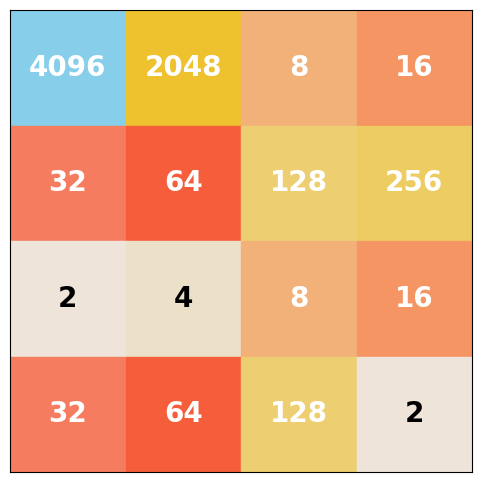

In [11]:
game = Game()
game.set_board([
    [4096, 2048, 8, 16],
    [32, 64, 128, 256],
    [2, 4, 8, 16],
    [32, 64, 128, 2]
])

display_game(game.board)

# Test new piece generation and basic movement

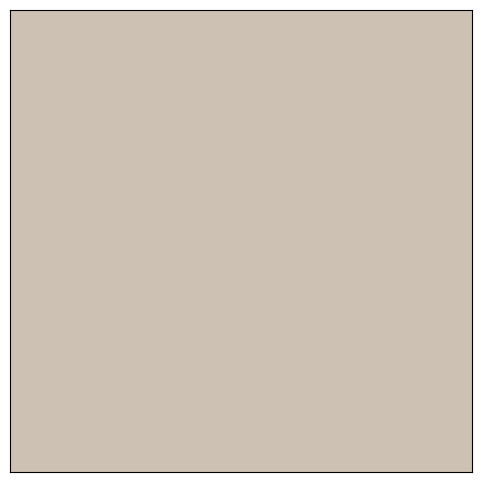

In [12]:
game = Game()
display_game(game.board)

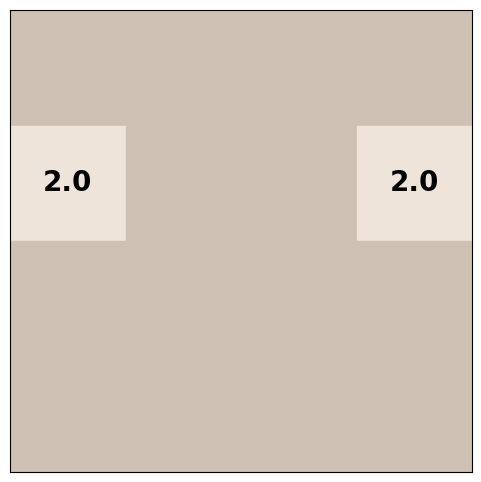

In [13]:
game.new_piece()
game.new_piece()
display_game(game.board)

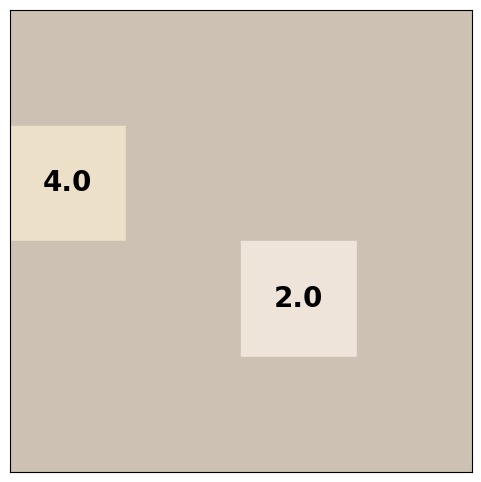

In [14]:
game.transition('L')
display_game(game.board)

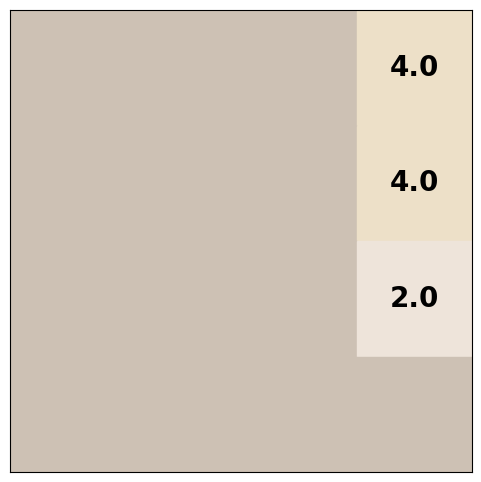

In [15]:
game.transition('R')
display_game(game.board)

# Test merge left

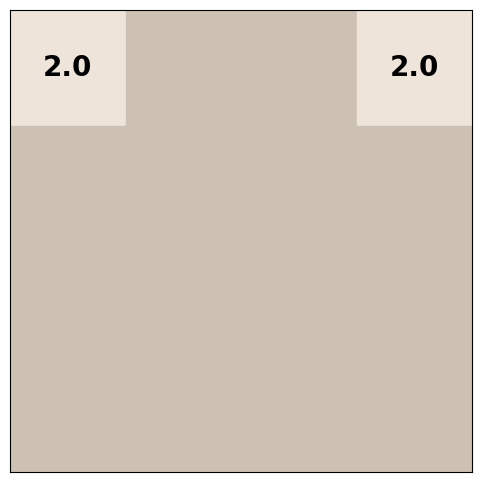

In [16]:
game = Game()
game.board[0][0], game.board[0][3] = 2, 2
display_game(game.board)

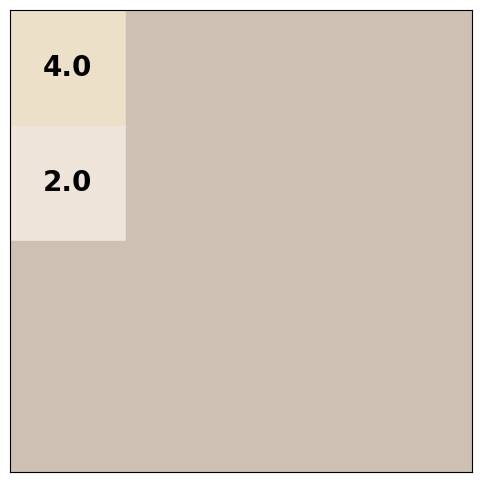

In [17]:
game.transition('L')
display_game(game.board)

# Test merge right

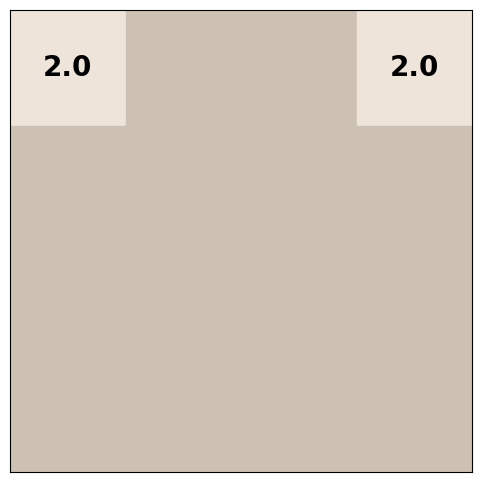

In [18]:
game = Game()
game.board[0][0], game.board[0][3] = 2, 2
display_game(game.board)

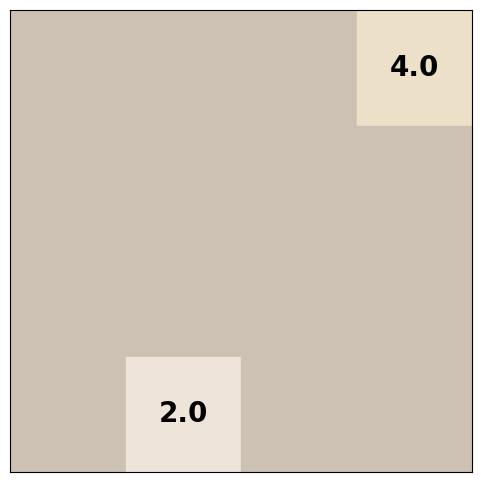

In [19]:
game.transition('R')
display_game(game.board)

# Test merge up

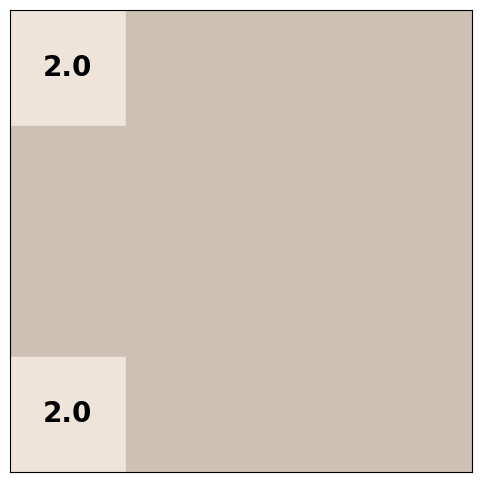

In [20]:
game = Game()
game.board[0][0], game.board[3][0] = 2, 2
display_game(game.board)

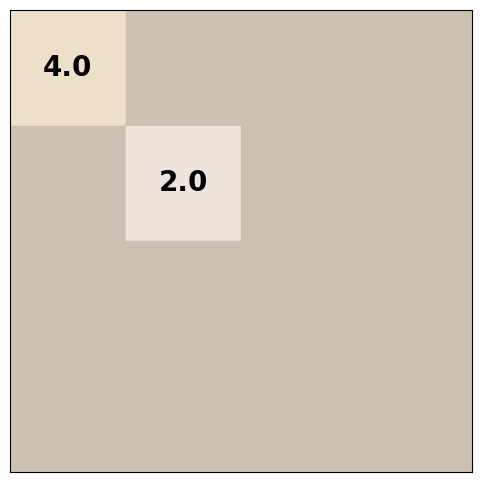

In [21]:
game.transition('U')
display_game(game.board)

# Test merge down

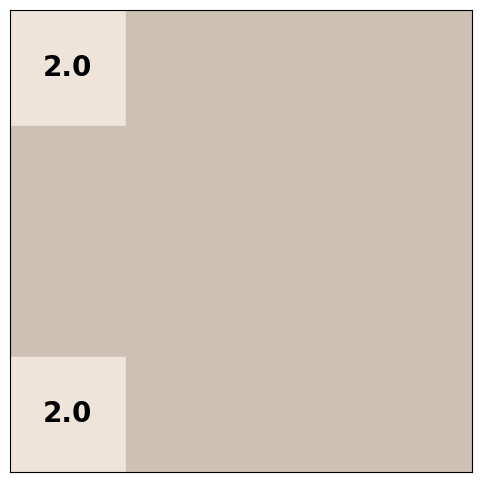

In [22]:
game = Game()
game.board[0][0], game.board[3][0] = 2, 2
display_game(game.board)

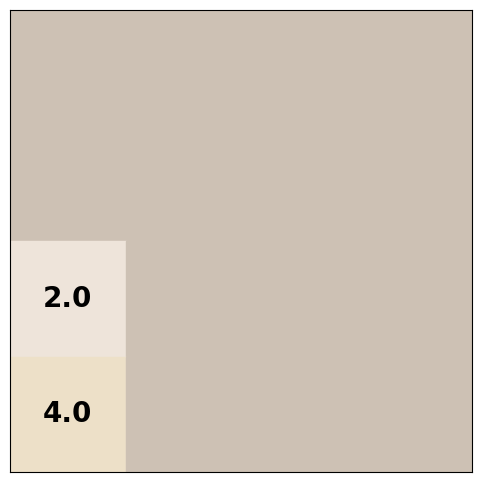

In [23]:
game.transition('D')
display_game(game.board)

# Test Expectimax

In [24]:
game = Game()
# Initialize the game board as desired or play normally
game.new_piece()  # Place an initial piece
game.new_piece()  # Place a second initial piece

expectimax = Expectimax(game)
best_move = expectimax.best_move(depth = 3)
print(f"Best move: {best_move}")

Best move: D


# Test MCTS

In [25]:
#Test MTCS
game = Game()
game.new_piece()  # Place an initial piece
game.new_piece()  # Place a second initial piece

mcts = MonteCarloTreeSearch(game)
best_move = mcts.best_move(simulations = 1000)  # Increase simulations for better accuracy
print(f"Best move: {best_move}")

Best move: R


# Linear Evaluation Function parameter test

In [ ]:
def test_linear_evaluation_function_curry(args):
    done = False
    game = None
    i = 0
    
    game = Game()
    game.new_piece()  # Place an initial piece
    game.new_piece()  # Place a second initial piece
    
    j = 0

    search = lambda: MonteCarloTreeSearch(game, linear_evaluation_function_curry(args))
    search_args = 128
    
    while not (game.has_lost() or game.has_won()):
        best_move = search().best_move(search_args)
        game.transition(best_move)
        j += 1

    i += 1
    
    return game

In [ ]:
for i in range(0, 200):
    board = test_linear_evaluation_function_curry([5, 0, 3, 0]).board
    max_val = np.max(board)

    print(i, max_val)
    
    if max_val > 1024:
        print('WON!')
        display_game(board)

In [ ]:
max_val = 0
max_args = None

max_avg = 0
max_avg_args = None

# Working best
# [4, 3, 2, 0]

args = [0, 0, 0, 0]
ubound = 6 
i = 0

for i in range(0, ubound ** len(args)):
    for j in range(0, len(args)):
        x = (i // (ubound ** j)) % ubound
        args[j] = x

    n = 6
    results = []
    
    for k in range(0, n):
        board = test_linear_evaluation_function_curry(args).board

        _max_val = int(np.max(board))
        results.append(_max_val)

        if _max_val > max_val:
            max_val = _max_val
            max_args = args
            print(f"New max: {max_val} {max_args}")

            if max_val >= 2048:
                print("WON!")
                display_game(board)

    avg = sum(results) / n

    if avg == max_avg:
        print(f"Tie max avg: {max_avg} {max_avg_args}")
    
    if avg > max_avg:
        max_avg = avg
        max_avg_args = args
        print(f"New max avg: {max_avg} {max_avg_args}")
    
    
(max_val, max_args, max_avg, max_avg_args)

# Test Harness

In [26]:
#evaluation_function = linear_evaluation_function_curry([4, 3, 2, 0])
evaluation_function = linear_evaluation_function_curry([5, 0, 3, 0])

def test_algorithm(algorithm_cls, game, param, attempts):
    results = []

    for attempt in range(1, attempts + 1):
        test_game = Game()
        test_game.new_piece()
        test_game.new_piece()        
        start_time = time.time()
        iterations = 0

        #print(f"\n--- Starting Attempt {attempt} ---")
        
        while not test_game.has_lost() and not test_game.has_won():
            algo = algorithm_cls(test_game, evaluation_function)
            bm = algo.best_move(param)
            #print(f"Iteration {iterations + 1}: Performing move '{bm}'")
            test_game.transition(bm)
            iterations += 1

        elapsed_time = time.time() - start_time
        max_tile = np.max(test_game.board)

        #print(f"\n--- Final Board for Attempt {attempt} ---")

        print(f"Attempt {attempt}: {max_tile}")
              
        if max_tile > 1024:
            display_game(test_game.board)
            
        results.append({
            'Attempt': attempt,
            'Iterations': iterations,
            'Time (s)': round(elapsed_time, 4),
            'Max Tile': max_tile
        })

    return results


def run_test_harness():
    print("\n=== 2048 Algorithm Test Harness ===")
    attempts = int(input("Enter the number of attempts per configuration: "))

    print("\nChoose Algorithm to Test:")
    print("1. Expectimax")
    print("2. Monte Carlo Tree Search (MCTS)")
    algo_choice = int(input("Enter 1 for Expectimax or 2 for MCTS: "))

    if algo_choice == 1:
        params = list(map(int, input("Enter depths for Expectimax (comma-separated): ").split(',')))
        algorithm_cls = Expectimax
        algo_name = "Expectimax"
    elif algo_choice == 2:
        params = list(map(int, input("Enter simulation counts for MCTS (comma-separated): ").split(',')))
        algorithm_cls = MonteCarloTreeSearch
        algo_name = "MCTS"
    else:
        print("\nInvalid choice. Exiting.")
        return

    test_results = []

    for param in params:
        print(f"\n=== Testing {algo_name} with Parameter {param} ===")
        game = Game()
        results = test_algorithm(algorithm_cls, game, param, attempts)
        test_results.extend([{'Algorithm': algo_name, 'Parameter': param, **res} for res in results])

    results_df = pd.DataFrame(test_results)
    print("\n=== Results Summary ===")
    print(results_df.to_string(index=False))
    return results_df


=== 2048 Algorithm Test Harness ===


Enter the number of attempts per configuration:  20



Choose Algorithm to Test:
1. Expectimax
2. Monte Carlo Tree Search (MCTS)


Enter 1 for Expectimax or 2 for MCTS:  2
Enter simulation counts for MCTS (comma-separated):  128



=== Testing MCTS with Parameter 128 ===
Attempt 1: 1024.0
Attempt 2: 1024.0
Attempt 3: 1024.0
Attempt 4: 2048.0


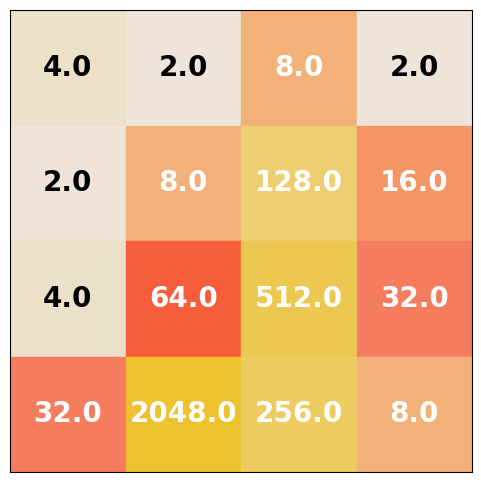

Attempt 5: 512.0
Attempt 6: 512.0
Attempt 7: 1024.0
Attempt 8: 1024.0
Attempt 9: 1024.0
Attempt 10: 1024.0
Attempt 11: 1024.0
Attempt 12: 128.0
Attempt 13: 1024.0


In [ ]:
run_test_harness()